In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

# Text generation with LSTM

This notebook contains the code samples found in Chapter 8, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----

[...]

## Implementing character-level LSTM text generation


Let's put these ideas in practice in a Keras implementation. The first thing we need is a lot of text data that we can use to learn a 
language model. You could use any sufficiently large text file or set of text files -- Wikipedia, the Lord of the Rings, etc. In this 
example we will use some of the writings of Nietzsche, the late-19th century German philosopher (translated to English). The language model 
we will learn will thus be specifically a model of Nietzsche's writing style and topics of choice, rather than a more generic model of the 
English language.

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [2]:
import keras
import numpy as np
import io, unicodedata, string

#path = keras.utils.get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
path = "/workspace/khoai23/opennmt/data/monolingual/vi/vie_wikipedia_2016_1M-sentences.txt"
text = io.open(path, "r").readlines()
print('Corpus sentences:', len(text))

Corpus sentences: 999999


(array([1.00000e+00, 1.00000e+00, 5.00000e+00, 1.40000e+01, 3.50000e+01,
        2.10000e+02, 1.03300e+03, 2.40180e+04, 1.60633e+05, 8.14049e+05]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

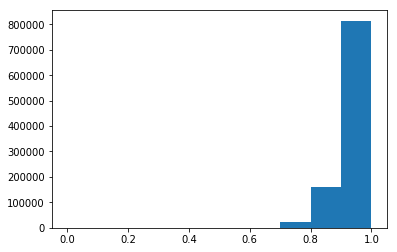

In [3]:
VN_chars = "ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂ ưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ"
assert 'a' < 'z'
valid_char = lambda x: 'a' < x.lower() < 'z' or x in VN_chars or x in string.punctuation
def valid_perc(paragraph):
    paragraph = unicodedata.normalize('NFKC', paragraph)
    num_chars = len(paragraph)
    num_valid_chars = sum( (1 if valid_char(c) else 0 for c in paragraph) )
    return float(num_valid_chars) / float(num_chars)

truetext = (l.split(" ", 1)[-1].strip() for l in text if l.strip() != "")
percs = [valid_perc(l) for l in truetext]

%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(percs, bins=10)

In [4]:
nan_percs = [np.nan if p<0.73 else p for p in percs]
worst_sent_idx = np.nanargmin(nan_percs)
print(text[worst_sent_idx])
print(text[worst_sent_idx].split("\t", 1)[-1].strip())

132709	Chức vụ Giám đốc Nhà máy điện hạt nhân Đầu Tiên được trao cho Nikolaev N.A. (Николаев Николай Андреевич).

Chức vụ Giám đốc Nhà máy điện hạt nhân Đầu Tiên được trao cho Nikolaev N.A. (Николаев Николай Андреевич).


(array([ 36339., 154317., 209381., 170427., 143797., 113447.,  77526.,
         56139.,  30885.,   6492.]),
 array([ 11. ,  35.4,  59.8,  84.2, 108.6, 133. , 157.4, 181.8, 206.2,
        230.6, 255. ]),
 <a list of 10 Patch objects>)

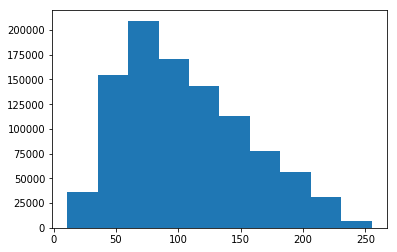

In [5]:
filtered_text = (line for p, line in zip(percs, text) if p >= 0.7)
normalized_text = [l.split("\t", 1)[-1].strip().lower() for l in filtered_text if l.strip() != ""]
plt.hist([len(l) for l in normalized_text], bins=10)

In [ ]:
! sed -n '800000,800020p' /workspace/khoai23/opennmt/data/monolingual/vi/vie_wikipedia_2016_1M-sentences.txt


Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [6]:
# Length of extracted character sequences
maxlen = 30

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

#for i in range(0, len(text) - maxlen, step):
#    sentences.append(text[i: i + maxlen])
#    next_chars.append(text[i + maxlen])
for l in normalized_text:
    for i in range(0, len(l)-maxlen, step):
        sentences.append(l[i: i + maxlen])
        next_chars.append(l[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
from collections import Counter
all_chars = Counter()
for l in normalized_text:
    all_chars.update(l)
# take only characters that have occurred more than 20 times
chars = {i+1:c for i, (c, occ) in enumerate(all_chars.most_common()) if occ >= 20}
chars[0] = None
char_indices = {char:i for i, char in chars.items()}
chars[0] = '?'

print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`

# encode to characters index for input and output
from keras.utils.np_utils import to_categorical   
x = np.array([[char_indices.get(c, 0) for c in sent] for sent in sentences])
y = np.array([char_indices.get(c, 0) for c in next_chars])
print(x.shape, y.shape)

#plt.hist([occ for c, occ in all_chars.items()], bins=20)
# Next, one-hot encode the characters into binary arrays.
#print('Vectorization...')
#x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
#y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
#for i, sentence in enumerate(sentences):
#    for t, char in enumerate(sentence):
#        x[i, t, char_indices[char]] = 1
#    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 25612874
Unique characters: 802
(25612874, 30) (25612874,)


## Building the network

Our network is a single `LSTM` layer followed by a `Dense` classifier and softmax over all possible characters. But let us note that 
recurrent neural networks are not the only way to do sequence data generation; 1D convnets also have proven extremely successful at it in 
recent times.

In [7]:
import tensorflow as tf
# Enforce dynamic session for Keras. Run to avoid GPU ram hogging
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

In [8]:
# Original Sequential, fast and reliable
from keras import layers, Model

#model = keras.models.Sequential()
inputs = layers.Input(shape=(maxlen,))
embedded = layers.Embedding(input_dim=len(chars), output_dim=128)(inputs)
sequenced = layers.LSTM(128, unroll=True)(embedded)
outputs = layers.Dense(len(chars), activation='softmax')(sequenced)
label_inputs = layers.Input(shape=())
model = Model(inputs=inputs, outputs=outputs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 128)           102656    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 802)               103458    
Total params: 337,698
Trainable params: 337,698
Non-trainable params: 0
_________________________________________________________________


~~Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:~~

Our target is single category entropy, thus we will use `tf.keras.losses.SparseCategoricalCrossentropy` instead

In [9]:
#from keras import losses
optimizer = keras.optimizers.RMSprop(lr=0.01)
def custom_fn(y_true, y_preds):
    y_true = tf.cast(y_true, tf.int32) # hack, reconvert value back to int
    y_true_onehot = tf.one_hot(y_true, len(chars), name="y_true_category")
    return tf.keras.losses.categorical_crossentropy(y_true_onehot, y_preds)
#import inspect
#inspect.signature(model.compile)
model.compile(loss=custom_fn, optimizer=optimizer) # keras.backend.sparse_categorical_crossentropy, target_tensors=label_inputs

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text

This is the code we use to reweight the original probability distribution coming out of the model, 
and draw a character index from it (the "sampling function"):

In [10]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


Finally, this is the loop where we repeatedly train and generated text. We start generating text using a range of different temperatures 
after every epoch. This allows us to see how the generated text evolves as the model starts converging, as well as the impact of 
temperature in the sampling strategy.

In [ ]:
import random
import sys

for epoch in range(1, 10):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    model.fit(x, y,
              batch_size=512,
              epochs=1)

    # Select a text seed at random
    sentence_seed = random.choice(normalized_text)
    start_index = random.randint(0, len(sentence_seed) - maxlen - 1)
    generated_text = sentence_seed[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text + '"')

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = [char_indices.get(c, 0) for c in generated_text]

            preds = model.predict(np.reshape(sampled, [1, maxlen]), verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]
            sampled = sampled[1:] + [next_index]

            #generated_text += next_char
            #generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

epoch 1
Epoch 1/1
13866496/25612874 [===============>..............] - ETA: 29:33 - loss: 2.2519


As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, all words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.


## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.